# Do computers actually think Nikola Jokic is the NBA MVP?

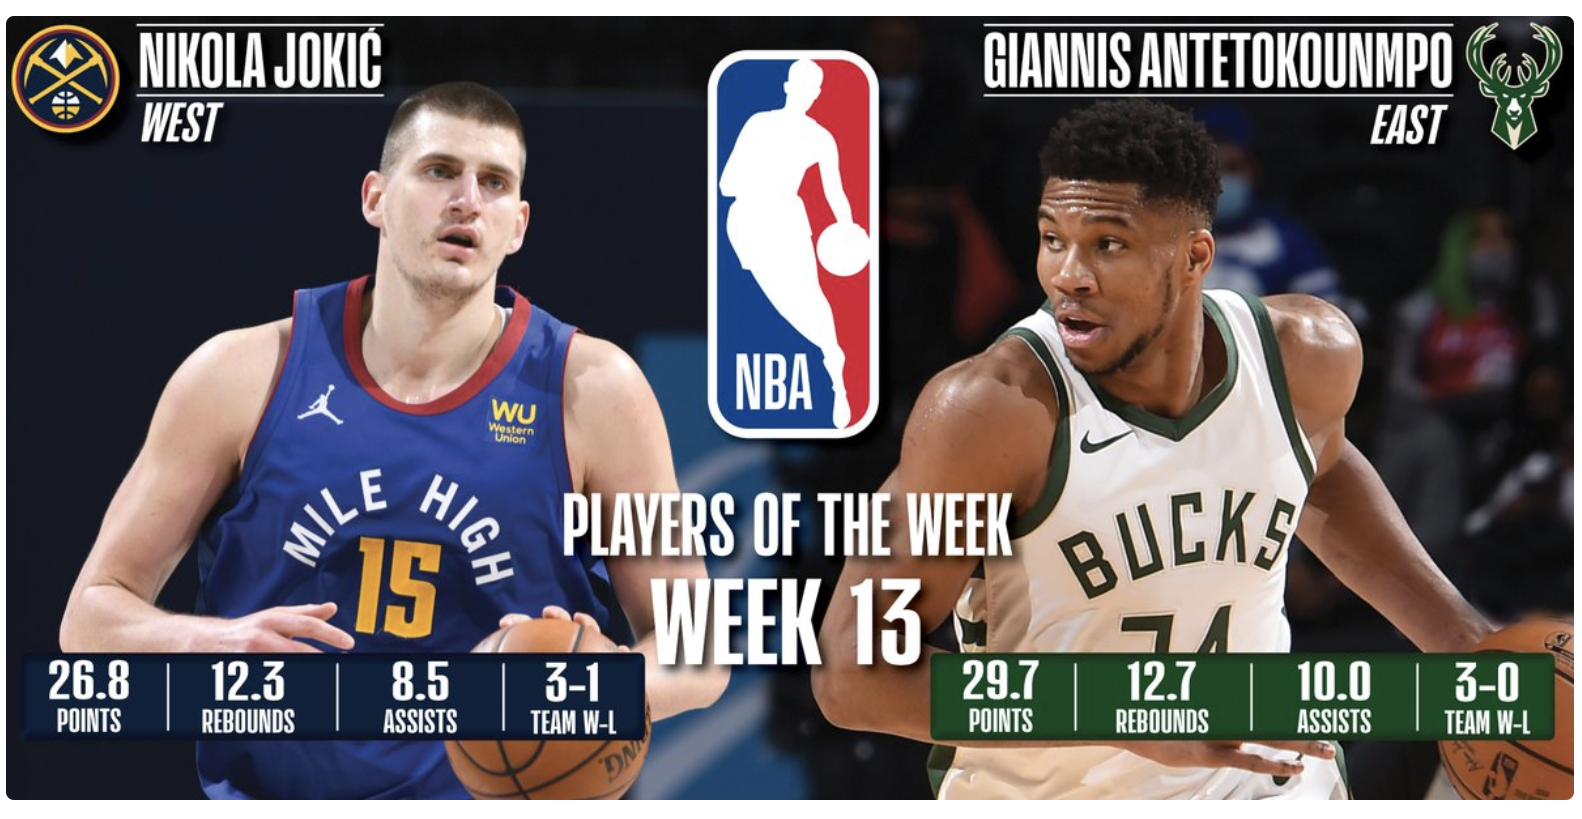
Image from https://www.nba.com/news/nikola-jokic-giannis-antetokounmpo-potw-week-13

The 2022 NBA Playoffs are in full-swing and one of the exciting parts about the playoffs had been how the MVP candidates performed overall while in the NBA playoffs. We know that Nikola Jokic won his second MVP award in a row from human voters, but if the process were up to computers who would actually win the MVP? This project explores that question through machine learning and is based off of similar project from [DataQuest in 2021](https://www.youtube.com/c/Dataquestio) with some added value in the forms of data visualization and basketball domain knowledge. 

## Project Layout
- Data Cleaning/Exploration
- Model-Building
- Creating customized Performance Metrics
- Feature Engineering through backtesting
- Ridge Regression Model Building
- Looking at feature biases from the model based on correlations through Data Visualization with plotly
- Random Forest Regressor compared with Ridge Regression
- Conclusions (**Was Nikola Jokic the NBA MVP in the eyes of computers?**)

## Data

The data was scraped and cleaned from [Basketball Reference](https://www.basketball-reference.com/)

## Import Packages

For this project, I'll be using regression algorithms to make predictions because the MVP Shares column is a continuous number and not a category. We'll be using Ridge Regression to limit overfitting and will compare it against a Random Forest. 

In [ ]:
# Import Needed packages

# Data Manipulation/Wrangling
import pandas as pd
import numpy as np
import random as rnd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Interactive Plotting
import plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly
import plotly.figure_factory as ff
import plotly.offline as pyo
from plotly.offline import init_notebook_mode, iplot
from IPython.display import HTML, Image
import plotly.express as px

init_notebook_mode(connected = True)
plotly.offline.init_notebook_mode(connected = True)
pyo.init_notebook_mode()

In [ ]:
# Import Machine Learning

In [ ]:
# Read in Data
stats = pd.read_csv("player_mvp_stats.csv")

In [ ]:
# Look at the data
stats.head()

It looks like I'll have to clean a little bit of the data for this part of the project. 

## Cleaning the Dataset

In [ ]:
# Drop the first column
del stats["Unnamed: 0"]

In [ ]:
# Check the output
stats.head()

Looks good. The next part of our cleaning process is to remove some of the null values in the dataset. 

In [ ]:
# Check for missing data
pd.isnull(stats).sum()

It looks like there a significant amount of null values for 3P% and FG% columns. This would make some sense as if a player didn't attempt a shot no % should be recorded. I need to confirm this by having a look at the values needed to calculate field goal and 3-point percentage. These are:
- FG%: FG/FGA
- 3P%: 3P/3PA

In [ ]:
# Look at the stats needed to generate %metrics
stats[pd.isnull(stats["3P%"])][["Player", "3P", "3PA"]]

It looks like I've confirmed my thoughts earlier. When the 3P% was null the attempts were equal to zero. I'm going to check this for the FG% stats as well. 

In [ ]:
# Look at stats needed to generate %metrics
stats[pd.isnull(stats["FG%"])][["Player", "FG", "FGA"]]

It looks like the same could be said for this category as well. I should probably look at this same thing for FT% as well. FT% stands for Free Throw Percentage. Another % metric. 

In [ ]:
# Look at stats needed to generate %metrics
stats[pd.isnull(stats["FT%"])][["Player", "FT", "FTA"]]

Looks like this is the case as well. Technically this could lower a player's percentage, but what we are making predictions on these percentages later so we'll fill these null values in as 0 for now. 

In [ ]:
# We're going to fill these null values for these categories wi
stats_updated = stats.fillna(0)

In [ ]:
# Check the output
pd.isnull(stats_updated).sum()

It looks like we are all good for some machine learning in a bit. First, I want to have a look at how some of the statistics interact with each other over time by creating some data visualizations. Some statistics that we know are highly valuable to the Share column we are going to predict on are the FG column,G GS(games started columns), PTS, AST, FT, W, L. Let's look at how some of these statistics interact with Wins `W` a column that important in MVP voting. If players want to win the MVP they usually have to be on a winning team. 

In [ ]:
# Visualize win distributions

plt.hist(stats['W'], color = "black")
plt.xlabel('Wins')
plt.title('Win Distribution')

It looks like a common win total is between 40-50 wins. I want to drill down into this category by looking at how some of the key metrics in terms of correlation to the MVP share column correlate with wins.  

In [ ]:
# Looking at FG and Wins
fig = px.scatter(stats, x = stats['W'], y = stats['FG'], color = stats['Share'],
                 title = 'Wins vs. FGs Made and Games Started')
fig.update_layout(
    title = {
        'text': 'Wins vs. FGs Made and Share of MVP votes',
        'y' : 0.9,
        'x' : 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Observations
We can see a ton of players with no share of the MVP voting. The players who had a high share of MVP voting are at the top right of the graph which indicates that MVP-level players typically scored a lot of points and were on winning teams. 

In [ ]:
# Visualizing PTS/Wins by Share
fig = px.scatter(stats, x = stats['W'], y = stats['PTS'], color = stats['Share'],
                 title = 'Wins vs. PTS Made and Share of MVP votes')
fig.update_layout(
    title = {
        'text': 'Wins vs. PTS Made and Games Started',
        'y' : 0.9,
        'x' : 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Observations
It looks like points scored and fg tell a very similar which would make some sense since when a player makes a field goal they get points. 

In [ ]:
# Looking at Assists and Wins
fig = px.scatter(stats, x = stats['W'], y = stats['AST'], color = stats['Share'],
                 title = 'Wins vs. Assists and Games Started')
fig.update_layout(
    title = {
        'text': 'Wins vs. Assists and Games Started',
        'y' : 0.9,
        'x' : 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Observations
It looks like players with high assist levels do have fairly high Share values. However, it doesn't seem to be as valuable as points were. 

In [ ]:
# Looking at Free Throws and Wins
fig = px.scatter(stats, x = stats['W'], y = stats['FT'], color = stats['Share'],
                 title = 'Wins vs. FTs Made and Games Started')
fig.update_layout(
    title = {
        'text': 'Wins vs. FTs Made and Games Started',
        'y' : 0.9,
        'x' : 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Observations
Players who make a lot of free throws and are on winning teams seem to have high levels of MVP shares. It makes some sense because points are extremely valueable to the MVP race, but getting to the free throw often seems to be indicative a high quality player. 

## Setting up our Machine Learning Models
The first step of this process will be having to set up our train and test sets as well as train our model. 

In [ ]:
# Have a look at the columns
stats_updated.columns

I want to use the numeric columns to make a prediction on the MVP winners. 

In [ ]:
# Create a list called predictors
predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS']

What we are trying to do is predict the percentage share of MVP votes that someone received based on all of these other predictors in a given year. 

In [ ]:
# Training Dataframes
train = stats_updated[stats_updated["Year"] < 2022]

In [ ]:
# Test Dataframe
test = stats_updated[stats_updated["Year"] == 2022]

In [ ]:
# Import Machine Learning Packages
from sklearn.linear_model import Ridge

reg = Ridge(alpha= .1)

I'll be using Ridge regression models to make predictions. I'm using Ridge regression because it's like Linear Regression, but is a form that tries to prevent overfitting. It shrinks Linear Regression coefficients in order to accomplish this. Let's get started with making predictions.

## Making predictions

In [ ]:
# fit the model
reg.fit(train[predictors], train["Share"])

In [ ]:
# Save as a variable

predictions = reg.predict(test[predictors])

In [ ]:
# Convert predictions numpy array into a pandas dataframe
predictions = pd.DataFrame(predictions, columns = ["Predictions"], index = test.index)

In [ ]:
# Check new output
predictions

Now that we've made predictions, I want to compare the actual values to those predictions. I'll need to combine some dataframes in order to do that. 

In [ ]:
# Combine the dataframes
combination = pd.concat([test[["Player", "Share"]], predictions], axis = 1)

In [ ]:
combination

Now, we have a dataframe that has the player, their actual share in the MVP voting, and the predictions for that player. At the moment, there are too many players in the dataframe. So we are going to subset for players who were actually in the MVP voting. 

In [ ]:
# Sort the dataframe to see MVP winners
combination.sort_values("Share", ascending = False).head(10)

### Observations
Nicola Jokic actually won the MVP. However, what's interesting is that he didn't have the highest predictions share. Giannis Antetokounmpo was actually predicted to win the MVP most often. Next, we have to identify an error metric to measure the performance of the algorithm. 

In [ ]:
# Import error metrics

from sklearn.metrics import mean_squared_error

# Apply mean_squared_error
mean_squared_error(combination["Share"], combination["Predictions"])

What we are looking at is the mean difference between the predicted value and the actual value. At the moment, this isn't particularly meaningful because a lot of the actual values are zero due to players not receiving any votes. I need to create an error metric that actually considers the rank of the player and not just if a player was in the dataframe.  

In [ ]:
# Sorting the dataframe on Share values
combination = combination.sort_values("Share", ascending = False)

# Assign a rank column
combination["Rk"] = list(range(1, combination.shape[0]+1))

In [ ]:
# Looking at the RK metric created
combination.head()

Now that we have this information sorted. We need to tie this into our predictions. 

In [ ]:
# Sort based on predictions
combination = combination.sort_values("Predictions", ascending = False)

# Assign a predicted rank column
combination["Predicted_Rk"] = list(range(1, combination.shape[0]+1))

In [ ]:
combination.head(10)

Immediately, we can see that some of the predictions based on previous data were a fair bit off the actual outcome of the rankings. Trae Young, and Anthony Davis didn't fair nearly as well as some might have thought. What we want to do is create an error metric to gauge how this went. 

In [ ]:
# first sort the dataframe
combination.sort_values("Share", ascending = False).head(10)

In [ ]:
# Error Metric
def find_ap(combination):
    actual = combination.sort_values("Share", ascending = False).head(5) # sort by share and take the top 5 mvp winners
    predicted = combination.sort_values("Predictions", ascending = False)
    ps = []
    found = 0 # how many top 5 mvps found
    seen = 1 # how many total records have we seen
    
    for index, row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            ps.append(found/seen)  # if found them, we'll append and give credit for that
            seen += 1
    return ps

In [ ]:
def find_ap(combination):
    actual = combination.sort_values("Share", ascending=False).head(5)
    predicted = combination.sort_values("Predictions", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index,row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            ps.append(found / seen)
        seen += 1

    return sum(ps) / len(ps)

In [ ]:
# Check the output
find_ap(combination)

We have a pretty high score which means, we didn't have to go to far outside of the top5 on our predictions. Or our predictions weren't that far off what actually happened. Now that we have a way to measure the performance of the algorithm we need to improve the model further. 

# Using Backtesting to Predict Each Year's winner

In [ ]:
# Create a list of all the years
years = list(range(1992, 2023))

In [ ]:
# Using backtesting
aps = []
all_predictions = []

# For loop that will loop through each year, append predictions into dataframe and have our average precision scores as well

for year in years[5:]: # start with 5th year of data because we need data to make predictions with before making predictions
    train = stats_updated[stats_updated["Year"] < year]
    test = stats_updated[stats_updated["Year"] == year]
    reg.fit(train[predictors], train["Share"])
    predictions = reg.predict(test[predictors])
    predictions = pd.DataFrame(predictions, columns = ["Predictions"], index = test.index)
    combination = pd.concat([test[["Player", "Share"]], predictions], axis = 1)
    all_predictions.append(combination)
    aps.append(find_ap(combination))
    

In [ ]:
# Calculate the mean average precision
sum(aps) / len(aps) * 100

So right now it looks like our model has an average precision of around 72%. It's not as strong across all of our data, but the accuracy overall is actually pretty good. 

In [ ]:
# Create add_ranks function to actually add the ranks columns generated before into the predictions

def add_ranks(predictions):
    predictions = predictions.sort_values("Predictions", ascending=False)
    predictions["Predicted_Rk"] = list(range(1,predictions.shape[0]+1))
    predictions = predictions.sort_values("Share", ascending=False)
    predictions["Rk"] = list(range(1,predictions.shape[0]+1))
    predictions["Diff"] = (predictions["Rk"] - predictions["Predicted_Rk"])
    return predictions


In [ ]:
# Check the output of the new functions

add_ranks(all_predictions[1])

### Observations
Looking at the new dataframe above we can see what the predicted rank for a player was, what their actual rank was and the difference in decision between the two. We were close on Michael Jordan, perfect on Karl Malone as indicated by the zero difference. 

In [ ]:
# Sorting the output
ranking = add_ranks(all_predictions[1])
ranking[ranking["Rk"] < 6].sort_values(["Diff"], ascending = False)

We now have the top 5 MVP vote getting from the 1998 season, with their predicted rank along with their actual rank. 

## Creating a Backtesting Function for easy results and model performance analysis


In [ ]:
# Backtesting function
def backtest(stats, model, year, predictors):
    # Using backtesting
    aps = []
    all_predictions = []

    # For loop that will loop through each year, append predictions into dataframe and have our average precision scores as well

    for year in years[5:]: # start with 5th year of data because we need data to make predictions with before making predictions
        train = stats_updated[stats_updated["Year"] < year]
        test = stats_updated[stats_updated["Year"] == year]
        reg.fit(train[predictors], train["Share"])
        predictions = reg.predict(test[predictors])
        predictions = pd.DataFrame(predictions, columns = ["Predictions"], index = test.index)
        combination = pd.concat([test[["Player", "Share"]], predictions], axis = 1)
        combination = add_ranks(combination)
        all_predictions.append(combination)
        aps.append(find_ap(combination))
        
    return sum(aps)/len(aps), aps, pd.concat(all_predictions)#mean average precision


In [ ]:
mean_ap, aps, all_predictions = backtest(stats_updated, reg, years[5:], predictors)

In [ ]:
mean_ap

It looks like our performance model is ready

## Evaluating Model Performance

In [ ]:
# Looking at all predictions for people 5 or lower and look at the largest difference between them
all_5 = all_predictions[all_predictions["Rk"] <= 5].sort_values("Diff")
all_5.head()

## Observing what kind of players the MVP metric struggled with

It looks like players like Jason Kidd, Glen Rice, and Steve Nash outshot their predictions by over 40 slots. Most notable is Steve Nash because he actually won the MVP despite being predicted to finish 46th. I'm going to drill down into Jason Kidd, Steve Nash, Glen Rice, Peja Stojakovic, and Joakim Noah's stats to see why they were misranked so badly.

If we remember from before the following categories had a high level of correlation to `Share`:
- FG (field goals)
- W (wins)
- L (losses)
- PTS (points)
- AST (assists)
- FT (free throws made)
- G (games played)
- GS (games started)

In [ ]:
# Subsetting to include only mvp candidates
mvp_cand = stats.sort_values("Share", ascending = False).head(150)
mvp_cand.head(5)

In [ ]:
# Exploring Pts
fig = px.bar(mvp_cand, x= mvp_cand["PTS"], y= mvp_cand["Player"], orientation='h', color = mvp_cand['Share'],  width=800, height=1000)
fig.update_layout(title= 'MVP Candidates Points Scored by their Share of MVP Votes',
                         barmode='stack', yaxis={'categoryorder':'total ascending'})

fig.show()

# Write chart as an HTML
fig.write_html('points_mvp.html')

### Pts/Share/Observations
- **Jason Kidd**: The year that Jason Kidd had an MVP vote share of .712 and finished second in MVP voting he scored 14.7 pts per game. We know that `PTS` were highly correlated with `Share` so the predictions being off for him in this case would make some sense. 
- **Steve Nash**: Steve Nash actually won the MVP award with a vote share of .835 and averaged 15.5 pts per game. This is in line with the earlier analysis on Jason Kidd. They both had low points scored totals which might mean the algorithm undervalued their contributions to their team based on that highly correlated feature. 
- **Glen Rice**: Glen Rice actually scored quite a few points, but he also had a lower vote share in the MVP race and finished 5th overall. There might have been a better candidate that year. The two leading candidates that year were Karl Malone and Michael Jordan, and they had larger vote shares of .857 and .832 respectively. By comparison with Glen Rice they both scored more points per game, so we might look at another statistic more in-depth. 
- **Peja Stojakovic**: Peja scored 24.2 points per game and had a vote share of .228 and finished 4th in MVP voting. I'm going to look at some of the other stats for him and how they relate to share. 
- **Joakim Noah**: Joakim Noah had the lowest point totals in the table averaging only 12.6 points per game. Being knowledgeable on the game, I know that Joakim Noah was highly valued defensive player and that his votes were based off of his contributions on that end and not points.

Next, I'm going to have a look at the players assists and how they correlate with MVP vote shares. 

In [ ]:
# Exploring Assists
fig = px.bar(mvp_cand, x= mvp_cand["AST"], y= mvp_cand["Player"], orientation='h', color = mvp_cand['Share'],  width=800, height=1000)
fig.update_layout(title= 'MVP Candidates Assists by their Share of MVP Votes',
                         barmode='stack', yaxis={'categoryorder':'total ascending'})

fig.show()

# Write chart as an HTML
fig.write_html('assists_mvp.html')

### Assists/Share/Observations
- **Jason Kidd**: Jason Kidd averaged 9.9 assists per game the year he had a .712 MVP vote share. This is probably a big reason for his success in the MVP voting. He was more of a facilitating type of player and voters might have recognized that more than our algorithm. 
- **Steve Nash**: Steve Nash averaged 11.5 assists per game the year he won the MVP. That's an abnormally high number for that statistic and speaks to the brilliance of the player. This certainly factored into his MVP vote shares and wasn't valued as highly by the Ridge Regression algorithm. 
- **Glen Rice**: Glen Rice averaged 2 assists per game the year he finished 5th in MVP voting. By comparison Karl Malone averaged 4.5 the year he won the MVP and scored more points, and the second place finisher Michael Jordan averaged 4.3 and scoring more points than Glen Rice.
- **Peja Stojakovic**: Peja averaged 2.1 assists per game the year he finished 4th in MVP voting which indicates he wasn't viewed as a facilitator by voters and this might have contributed to him not getting as many votes. 
- **Joakim Noah**: Joakim Noah averaged 5.4 assists per game the year he took 4th. This is a relatively high number by center standards, but still not significant enough to explain why he received so many votes. 

Next, I'm going to have a look at the player's wins and how they correlate with MVP vote shares. 

In [ ]:
# Exploring Wins
fig = px.bar(mvp_cand, x= mvp_cand["W"], y= mvp_cand["Player"], orientation='h', color = mvp_cand['Share'],  width=800, height=1000)
fig.update_layout(title= 'MVP Candidates Games Won by their Share of MVP Votes',
                         barmode='stack', yaxis={'categoryorder':'total ascending'})

fig.show()

# Write chart as an HTML
fig.write_html('wins_mvp.html')

### Wins/Share/Observations
- **Jason Kidd**: Jason Kidd's team won 52 games the year he finished second in MVP voting. Wins is a feature highly correlated with MVP vote share which means his role on a winning team may have contributed quite a bit to his total votes.  
- **Steve Nash**: Steve Nash won the MVP and was a member of a 62 win team the year he did. 62 wins is one of the best win marks of all-time and his assist totals on that team along with his team's success probably contributed to the voter's sentiments. The algorithm correlates wins quite a bit with MVP vote shares, so he'd perform well here.  
- **Glen Rice**: Glen Rice was on a 54 win team the year he finished 5th, but by comparison Michael Jordan was on a staggering 69 win team and Karl Malone was on a 64 win team that year. The voters that year were sure to look at those win totals over Glen Rice's win totals. 
- **Peja Stojakovic**: Peja was on a 55 win team, but the year he finished 4th he was in the race against Kevin Garnett and Tim Duncan. Both players were known for their defensive contributions and their team's success. Kevin Garnett's Timberwolves won 58 games and Tim Duncan's Spurs won 57 games both bettering Peja's Kings. 
- **Joakim Noah**: Joakim Noah's Bulls won 48 games the year he finished 4th in MVP voting which further supports the idea, that his defensive contributions were a big part of his MVP vote shares. 

Next, I'm going to have a look at the player's FT's and how they correlate to win shares.

In [ ]:
# Exploring Ft's
fig = px.bar(mvp_cand, x= mvp_cand["FT"], y= mvp_cand["Player"], orientation='h', color = mvp_cand['Share'],  width=800, height=1000)
fig.update_layout(title= 'MVP Candidates Free Throws Made by their Share of MVP Votes',
                         barmode='stack', yaxis={'categoryorder':'total ascending'})

fig.show()

# Write chart as an HTML
fig.write_html('ft_mvp.html')

### FT/Share/Observations
- **Jason Kidd**: Jason Kidd averaged 2.4 free throws made per game. This category didn't contribute much to his total MVP vote shares. 
- **Steve Nash**: Steve Nash scored 2.3 free throws per game, the story is the same as Jason Kidd.   
- **Glen Rice**: Glen Rice scored 5.3 free throws per game, this is a pretty good number. Still less than Karl Malone's 6.4 free throws per game, and Michael Jordan's 5.9 per game. 
- **Peja Stojakovic**: Peja averaged 4.9 per game. 
- **Joakim Noah**: Joakim Noah had 3.1 made free throws per game, again his offensive contributions don't seem to weigh much on voter's and definitely not by the Ridge regression algorithm. 


## Algorithm faults in predictions
- The ridge regression algorithm had a clear emphasis on PTS scored and FG's made when making predictions for MVP voter shares. - In the cases of Jason Kidd and Steve Nash their abnormally high assist totals and team records contributed a lot to their vote shares from human voters, but weren't as valued by the algorithm. They both scored less than 16 pts per game which is could be a big reason for the algorithm's errors.
- Glen Rice had high point totals, but had low assist totals and his team wasn't as successful as the two front-runners Michael Jordan and Karl Malone. He also trailed them in both points scored and assists. 
- Peja Stojakovic scored well and was on a winning team, but similar to Glen Rice he was overlooked by more prolific players. Both Kevin Garnett and Tim Duncan were defensive stars and had more successful teams which might be why he was penalized a bit along with low assist totals. 
- Joakim Noah is a true anomaly in the MVP voting. He wasn't a prolific scorer, wasn't on a winning team, didn't get to the free throw line often, and just generally lacked offensive categories. But knowing how that year played out, I know he was a huge defensive presence and received person votes based on that. The computer algorithm might improve on making prediction for him by incorporating some advanced defensive metrics into it's decision process. 

## Diagnosing the coefficients of the variables

In [ ]:
# Which variables most important to regression
pd.concat([pd.Series(reg.coef_), pd.Series(predictors)], axis = 1).sort_values(0, ascending = False)

It looks like the most important predictors to this type of algorithm is the `eFG%` which stands for effective field goal percentage, `DRB` defensive rebounds, `W/L%` which is for the win-loss percentage. 

## Improve the Model Performance

Next, I'm going to add some further predictors to improve the model performance. 

In [ ]:
# This will divide the players average for each of the values by the mean
stat_ratios = stats_updated[["PTS", "AST", "STL", "BLK", "3P", "Year"]].groupby("Year").apply(lambda x: x/x.mean())

In [ ]:
# Check the output
stat_ratios.head()

In [ ]:
# Add these new ratios to the dataframe
stats_updated[["PTS_R", "AST_R", "STL_R", "BLK_R", "3P_R"]] = stat_ratios[["PTS", "AST", "STL", "BLK", "3P"]]

In [ ]:
stats_updated.tail(10)

Now, I have the ratio between the players and the league average. For example, Malcolm Brogdon averaged quite a few more assists than the average player. 

In [ ]:
# Add values generated to our predictors list from before

predictors += ["PTS_R", "AST_R", "STL_R", "BLK_R", "3P_R"]

In [ ]:
# Run the prediction code from before to see how the ratio features affect our predictions
mean_ap, aps, all_predictions = backtest(stats_updated, reg, years[5:], predictors)

In [ ]:
mean_ap

The overall precision improve a little. 

## Adding positional information
We haven't included positional information because the information was in string form. However, we can include this information by assigning each positional string as numerical category. 

In [ ]:
# Assign positions to a numerical category
stats_updated["NPos"] = stats_updated["Pos"].astype("category").cat.codes

In [ ]:
# Check the output
stats_updated.head()

We'll also use this on the team column. 

In [ ]:
# Assign teams to a numerical category
stats_updated["NTm"] = stats_updated["Tm"].astype("category").cat.codes

In [ ]:
# Check output
stats_updated.head()

The issue with these new categories is that they don't follow a linear relationship. They aren't ranked in any way, but just add more information. Linear models won't pick this up well, but a random forest can do something with this information. 

## Random Forest Model


In [ ]:
# Import Model
from sklearn.ensemble import RandomForestRegressor

# Initialize
rf = RandomForestRegressor(n_estimators=500, random_state=1, min_samples_split=5)

# Run model
mean_ap, aps, all_predictions = backtest(stats_updated, rf, years[5:], predictors + ["NPos", "NTm"])


In [ ]:
mean_ap

Compare with regression model performance

In [ ]:
mean_ap, aps, all_predictions = backtest(stats_updated, reg, years[5:], predictors)

In [ ]:
mean_ap

## Conclusions
- Our algorithm actually predicted that Giannis Antentokounmpo was the 2022 NBA MVP.
- The Ridge Regression model we created outperformed the Random Forest model slightly.
- Both models were in the 70% accurate range for predicting a player's MVP vote shares.
- The models were highly biased towards points scored and wins in their predictions. While the predictions were strong, we could improve them further by incorporating advanced defensive metrics so that more value is placed on more defensively-minded players. 

### What I learned
- I learned how to scrape and clean data from [Basketball Reference](https://www.basketball-reference.com/)
- Create customized metrics for regression models by taking into account different parts of the data. 
- Improve model performance through backtesting.
- Creating ratio metrics based off of existing columns in the dataset to provide more information (feature engineering).
- Drilling down into model biases through advanced data visulization.

### References
[DataQuest YouTube Channel](https://www.youtube.com/c/Dataquestio) for web-scraping and model-building
[Plotly](https://plotly.com/python/horizontal-bar-charts/#configure-horizontal-bar-chart) for data viz